---
title: Fourier Series
description: Approximating any 2D shape from sampled points using Fourier Series.
imgUrl: ./src/notebooks/fourier-series-high-quality.gif
imgAlt: fourier-series
imgSize: '(min-width: 30em) 50vw, 100vw'
pictureClass: grid-column-full
imgClass: img-full

date: "2023-08-12"
tags:
  - Fourier Series
  - Maths
layout: layouts/post.njk


use_katex: true
use_prism: true
---

In [33]:
%pip install svgpathtools moviepy --quiet

Note: you may need to restart the kernel to use updated packages.


In [179]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
def _draw(Xs, title='', scatter=False, show=True, alpha=1.0, s=0.2):
  if not isinstance(Xs, list):
    Xs = [Xs]
  fig, ax = plt.subplots(1, 1, figsize=(2, 1), dpi=400)
  for X in Xs:
    if scatter:
      ax.scatter(X.real, X.imag, s=s, c='k', marker='o', lw=0, alpha=alpha)
    else:
      ax.plot(X.real, X.imag, 'k', lw=s, alpha=alpha)
  ax.set_title(title)
  ax.axis('equal')
  ax.invert_yaxis()
  ax.axis('off')
  if show:
    plt.show()
  return fig, ax

def plot(Xs, title='', show=True, alpha=1.0, s=0.2):
  return _draw(Xs, title=title, scatter=False, show=show, alpha=alpha, s=s)

def scatter(Xs, title='', show=True, alpha=1.0, s=0.2):
  return _draw(Xs, title=title, scatter=True, show=show, alpha=alpha, s=s)

# What do we want to do?

We want to find a polynomial function that can plot any kind of 2D shape using only sampled points. We will use Fourier series to solve this problem.

## First, lets sample some points from an image

To sample points, we will use svg files and sample points from the path elements.

### 1. Parse svg file

An svg file is composed of paths, each paths is composed of segment, a segment can be a line or a curve (eg. CubicBezier).

number of paths: 30
number of elements in `paths[0]`: 53
type of `paths[0][0]`: <class 'svgpathtools.path.CubicBezier'>


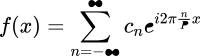

In [106]:
from svgpathtools import svg2paths
from IPython.display import SVG

paths = svg2paths('formula.svg')[0]

print(f'''number of paths: {len(paths)}
number of elements in `paths[0]`: {len(paths[0])}
type of `paths[0][0]`: {type(paths[0][0])}''')

SVG('formula.svg')

Moreover, the svgpathtools library give us the access to the polynomial function that describe each segment. Each segment polynome takes a parameter $t$ in $[0,1]$ and return a complex number. The complex number is the point on the segment for the given parameter $t$.

Here for example, we sampled 20 points from the 35th segment of the 2nd path:

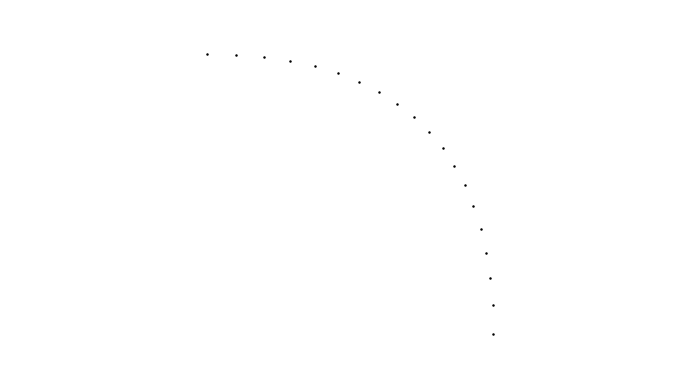

In [107]:
t = np.linspace(0, 1, 20)
segment = paths[2][35]

scatter(segment.poly()(t));

### 2. Sample points from svg file

Our goal here is to sample $N$ points from the svg file. By using the length each segments, we can sample the points proportionally to the length of each segment.

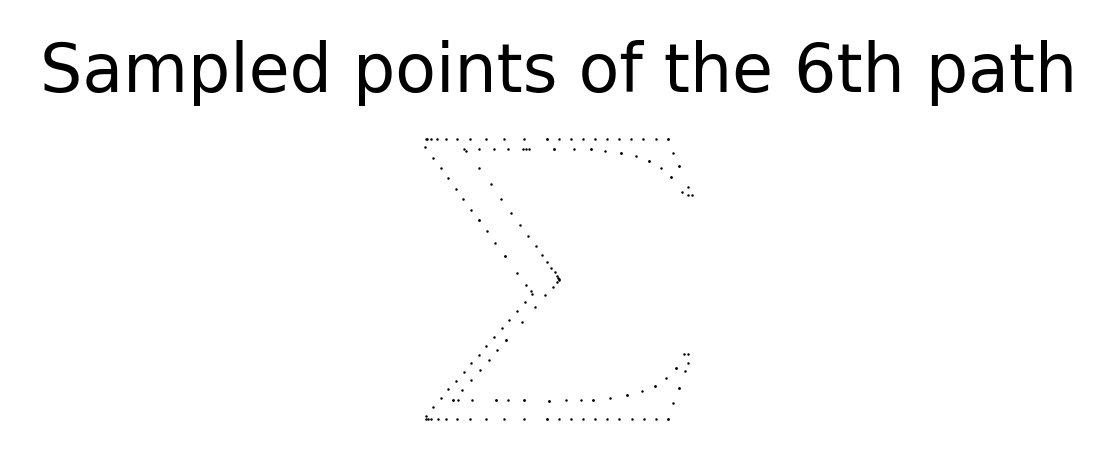

In [167]:
N_POINTS = 1000

total_length = sum(path.length() for path in paths)

def get_t(seg):
  prop = seg.length() / total_length
  n = round(prop * N_POINTS)
  if n == 1:
    return [.5] # center of the segment
  return np.linspace(0, 1, n)

sampled_points_by_path = []
for path in paths:
  path_points = [seg.poly()(get_t(seg)) for seg in path]
  path_points = np.hstack(path_points)
  sampled_points_by_path.append(path_points)

scatter(sampled_points_by_path[6],
        title='Sampled points of the 6th path');

The sampled points of the image looks like this:

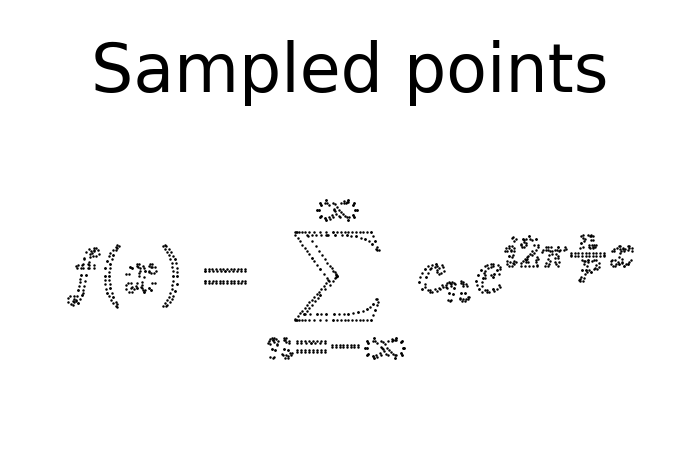

In [168]:
scatter(sampled_points_by_path,
        title=f'Sampled points');

## Using the sampled points, we can now create the reference function

The idea is to create a reference function $f_{data}^{(i)}(t)$ for each path that maps the time $t \in [0,1]$ to the closest sampled point to the time $t$ of the path $i$.

In [169]:
def f_data_i(i, t):
  points = sampled_points_by_path[i]
  closest_idx = (t*(points.shape[0]-1)).astype(int)
  return points[closest_idx]

def f_data(t):
  return [f_data_i(i, t)
          for i in range(len(sampled_points_by_path))]

In [170]:
import base64
from IPython.display import Image

duration = 5 # seconds
selected_path = 6

fig, ax = scatter(f_data(np.linspace(0,1,1000))[selected_path], show=False, s=.1)
ax.set_xlim([60, 129])
ax.set_ylim([9, 44])
im_bg = mplfig_to_npimage(fig)
plt.close(fig)

def make_frame(frame_t):
  t = frame_t / duration
  fig, ax = scatter(f_data(np.array([t]))[selected_path], show=False, s=4)
  ax.set_xlim([60, 129])
  ax.set_ylim([9, 44])
  im = mplfig_to_npimage(fig)
  im_output = im_bg.copy()
  im_output[im != 255] = im[im != 255]
  plt.close(fig)
  return im_output

clip = mpy.VideoClip(make_frame, duration=duration)
clip.write_gif('reference-fct.gif', fps=15)

t:  72%|███████▏  | 54/75 [02:21<00:01, 12.00it/s, now=None]

MoviePy - Building file reference-fct.gif with imageio.


For example, bellow, the big circle is the plot of $f_{data}^{(6)}$ which plots the 6th path with $t$ going from $0$ to $1$.

![gif](./reference-fct.gif)

Of course, we could use these points to plot the final image but the resulted function will not be smooth nor a polynome.

*For brievity, we will use the notation $f_{data}(t)$ for the rest of the notebook that refers to one of the reference functions $f_{data}^{(i)}(t)$.*

## Now, we can use the $f_{data}$ to compute the Fourier coefficients $c_n$

Recap that, here, the Fourier series of $f_{data}(t)$ is given by

$$
f_{data}(t) = \sum_{n=-\infty}^{\infty} c_n e^{2 \pi i n t}
$$

To extract the coefficients $c_m$, we multiply both sides by $e^{-2 \pi i m t}$ and integrate over the interval $[0, 1]$:

$$
\begin{aligned}
\int_0^1 f_{data}(t) e^{-2 \pi i m t} dt &= \sum_{n=-\infty}^{\infty} c_n \int_0^1 e^{2 \pi i n t} e^{-2 \pi i m t} dt \\
&= \sum_{n=-\infty}^{\infty} c_n \int_0^1 e^{2 \pi i (n - m) t} dt \\
&= c_m \underbrace{\int_0^1 e^{2 \pi i \bm{0} t} dt}_{= 1} + \sum_{n \neq m} c_n \underbrace{\int_0^1 e^{2 \pi i (n - m) t} dt}_{= 0} \\
&= c_m
\end{aligned}
$$

In [171]:
def compute_c_i(i, n):
  t = np.linspace(0, 1, 1000)
  fx = f_data_i(i, t)
  integrand = fx*np.exp(-2j*np.pi*n[:, None]*t)
  cn = np.trapz(integrand)
  return cn

We can now approximate the reference function with a truncated Fourier series.

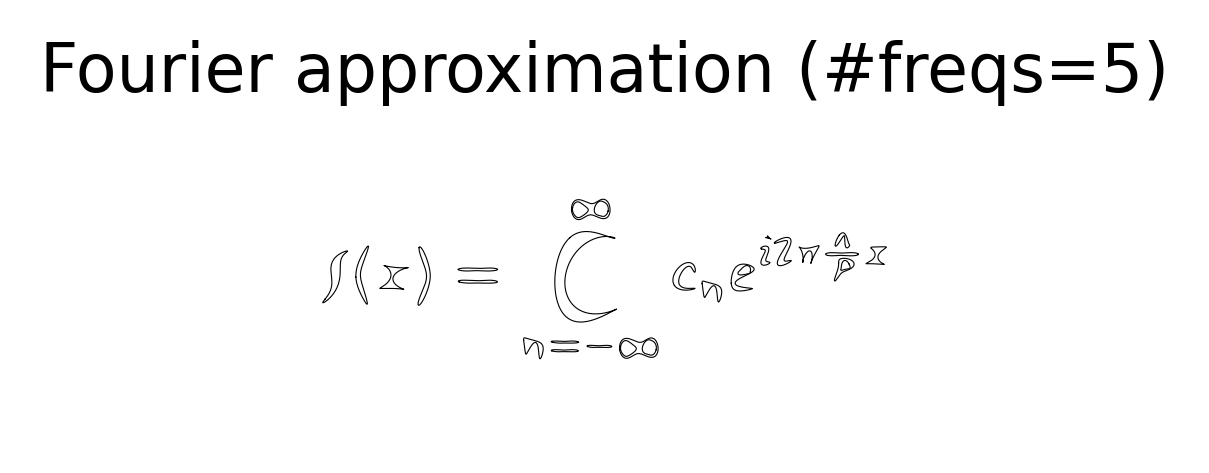

In [172]:
def f_approx_i(i, t, n_freqs):
  n = np.arange(-n_freqs//2, n_freqs//2+1)
  cn = compute_c_i(i, n)
  n, cn = n[:, None], cn[:, None] # add new axis for broadcasting
  f_approx = np.sum(cn*np.exp(2j*np.pi*n*t), axis=0)
  return f_approx

def f_approx(t, n_freqs):
  return [f_approx_i(i, t, n_freqs)
          for i in range(len(sampled_points_by_path))]

t = np.linspace(0, 1, 1000)
plot(f_approx(t, n_freqs=6),
     title=f'Fourier approximation (#freqs=5)');

Here, for example, the number "2" symbole (22th path) can be represented by the following polynomials:

$$
\begin{aligned}
f_{data}^{(22)}(t) \approx & (-438-104i)e^{-3*2\pi it} \\
& + (40-60i)e^{-2*2\pi it} \\
& + (354-1141i)e^{-1*2\pi it} \\
& + (156814+19842i)e^{0*2\pi it} \\
& + (-1200 -1724i)e^{1*2\pi it} \\
& + (62   +39i)e^{2*2\pi it} \\
& + (-121  +657i)e^{3*2\pi it} \\
\end{aligned}
$$

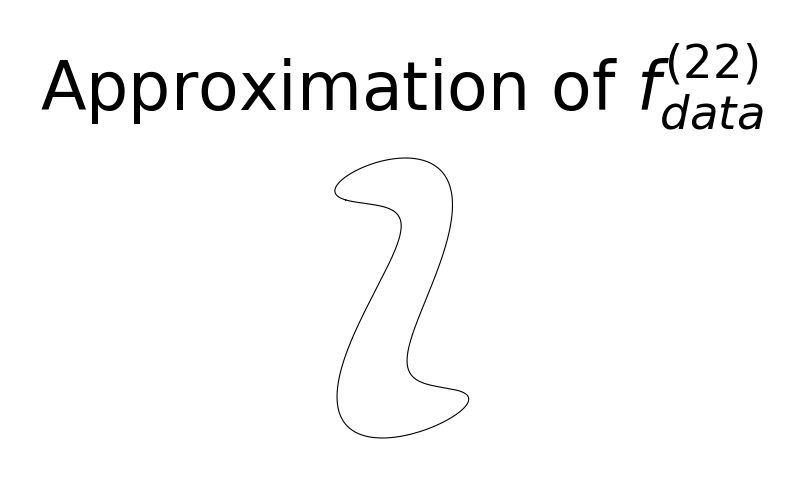

In [173]:
cn = np.array([
  -438-104j,
  40-60j,
  354-1141j,
  156814+19842j,
  -1200-1724j,
  62+39j,
  -121+657j])

t = np.linspace(0, 1, 1000)
n = np.arange(-3, 4)
cn, n = cn[:,None], n[:,None]
f_22 = np.sum(cn * np.exp(2j * np.pi * n * t), axis=0)

plot(f_22, title='Approximation of $f_{data}^{(22)}$');

## We're done, we can play with the number of frequencies to get accurate result

In [180]:
duration = 5 # seconds
n_freqs_max = 50

def make_frame(t):
  n_freqs = max(int(t/duration*n_freqs_max), 1)
  fig, _ = plot(f_approx(tx, n_freqs), show=False)
  im = mplfig_to_npimage(fig)
  plt.close(fig)
  return im

clip = mpy.VideoClip(make_frame, duration=duration)
clip.write_gif('fourier-series.gif', fps=15)

t:  72%|███████▏  | 54/75 [04:29<00:01, 12.00it/s, now=None]

MoviePy - Building file fourier-series.gif with imageio.


![gif](./fourier-series-high-quality.gif)